In [1]:
import bioframe as bf
from datasets import load_dataset
from gpn.data import GenomeMSA
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/mpra/processed"

In [3]:
models = [
    "CADD.RawScore",
    "phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_models = models[-1:] + [
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    #"LongSafari/hyenadna-large-1m-seqlen-hf",
    #"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = load_dataset(f"../../{dataset_path}", split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,Tags,DNA,RNA,Value,P-Value,Element,CADD,phyloP-100-vertebrates,GPN-MSA
0,2,60494940,C,A,146,2785,6772,-0.05,0.38889,BCL11A,0.516297,0.727,-0.750451
1,2,60494940,C,G,60,975,2436,-0.13,0.13721,BCL11A,0.499044,0.727,-0.194103
2,2,60494940,C,T,1084,8543,16057,-0.70,0.00000,BCL11A,0.456772,0.727,2.813937
3,2,60494941,C,A,596,9425,23430,-0.08,0.00413,BCL11A,-0.309534,-0.739,-1.609539
4,2,60494941,C,G,75,1506,3697,-0.06,0.47756,BCL11A,-0.326787,-0.739,-1.638036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39165,7,156791602,G,C,358,2279,7044,0.04,0.39490,ZRSh-13h2,-1.231087,-6.461,-7.577469
39166,7,156791602,G,T,1676,12030,37310,0.10,0.00001,ZRSh-13h2,-1.218929,-6.461,-8.451139
39167,7,156791603,C,A,25,107,309,-0.17,0.33374,ZRSh-13h2,-1.201227,-6.793,-9.344140
39168,7,156791603,C,G,654,4748,14458,0.06,0.09092,ZRSh-13h2,-1.218479,-6.793,-8.859602


In [4]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "Enformer": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,Tags,DNA,RNA,Value,P-Value,Element,...,NT_embedding_2550,NT_embedding_2551,NT_embedding_2552,NT_embedding_2553,NT_embedding_2554,NT_embedding_2555,NT_embedding_2556,NT_embedding_2557,NT_embedding_2558,NT_embedding_2559
0,2,60494940,C,A,146,2785,6772,-0.05,0.38889,BCL11A,...,595.340576,571.458984,306.855042,713.731995,280.904968,639.018616,611.724182,393.658295,246.889572,438.870209
1,2,60494940,C,G,60,975,2436,-0.13,0.13721,BCL11A,...,595.412415,571.153931,306.759644,714.082642,280.716614,638.803955,613.168945,393.661713,247.011124,439.019897
2,2,60494940,C,T,1084,8543,16057,-0.70,0.00000,BCL11A,...,595.328857,571.041870,306.902039,713.725098,280.945099,638.307739,612.376953,393.744720,246.844040,438.470886
3,2,60494941,C,A,596,9425,23430,-0.08,0.00413,BCL11A,...,593.347656,625.938232,320.276978,750.433105,275.491791,582.535522,625.180237,415.684326,251.629257,489.781494
4,2,60494941,C,G,75,1506,3697,-0.06,0.47756,BCL11A,...,593.250732,625.783081,320.301300,750.523743,275.479004,582.367126,626.136963,415.015259,251.971130,488.997864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39165,7,156791602,G,C,358,2279,7044,0.04,0.39490,ZRSh-13h2,...,486.290924,368.458801,367.774261,758.900330,292.959381,725.619385,483.129639,444.974670,288.532288,566.185303
39166,7,156791602,G,T,1676,12030,37310,0.10,0.00001,ZRSh-13h2,...,485.968262,368.920074,368.930817,758.965576,290.691437,722.373108,482.941101,442.876526,288.728088,555.536621
39167,7,156791603,C,A,25,107,309,-0.17,0.33374,ZRSh-13h2,...,428.281250,442.092987,339.231812,836.688110,247.580978,644.393799,482.822723,497.064911,270.218353,438.244843
39168,7,156791603,C,G,654,4748,14458,0.06,0.09092,ZRSh-13h2,...,429.095093,442.222351,338.345215,837.419922,247.332809,645.774658,483.212708,496.339264,270.630676,438.434357


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [6]:
# Intersection is only 126
"""
enformer = pd.read_parquet("../../results/enformer/merged.correct_ref_alt.parquet")
cols = ["chrom", "pos", "ref", "alt"]
V = V.merge(enformer, on=cols, how="inner")
models += [
    "Enformer_l2",
    #"Enformer_l1",
    #"Enformer_linf",
]
V
""";

In [7]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,Tags,DNA,RNA,Value,P-Value,Element,...,NT_embedding_2550,NT_embedding_2551,NT_embedding_2552,NT_embedding_2553,NT_embedding_2554,NT_embedding_2555,NT_embedding_2556,NT_embedding_2557,NT_embedding_2558,NT_embedding_2559
0,2,60494940,C,A,146,2785,6772,-0.05,0.38889,BCL11A,...,595.340576,571.458984,306.855042,713.731995,280.904968,639.018616,611.724182,393.658295,246.889572,438.870209
1,2,60494940,C,G,60,975,2436,-0.13,0.13721,BCL11A,...,595.412415,571.153931,306.759644,714.082642,280.716614,638.803955,613.168945,393.661713,247.011124,439.019897
2,2,60494940,C,T,1084,8543,16057,-0.70,0.00000,BCL11A,...,595.328857,571.041870,306.902039,713.725098,280.945099,638.307739,612.376953,393.744720,246.844040,438.470886
3,2,60494941,C,A,596,9425,23430,-0.08,0.00413,BCL11A,...,593.347656,625.938232,320.276978,750.433105,275.491791,582.535522,625.180237,415.684326,251.629257,489.781494
4,2,60494941,C,G,75,1506,3697,-0.06,0.47756,BCL11A,...,593.250732,625.783081,320.301300,750.523743,275.479004,582.367126,626.136963,415.015259,251.971130,488.997864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39165,7,156791602,G,C,358,2279,7044,0.04,0.39490,ZRSh-13h2,...,486.290924,368.458801,367.774261,758.900330,292.959381,725.619385,483.129639,444.974670,288.532288,566.185303
39166,7,156791602,G,T,1676,12030,37310,0.10,0.00001,ZRSh-13h2,...,485.968262,368.920074,368.930817,758.965576,290.691437,722.373108,482.941101,442.876526,288.728088,555.536621
39167,7,156791603,C,A,25,107,309,-0.17,0.33374,ZRSh-13h2,...,428.281250,442.092987,339.231812,836.688110,247.580978,644.393799,482.822723,497.064911,270.218353,438.244843
39168,7,156791603,C,G,654,4748,14458,0.06,0.09092,ZRSh-13h2,...,429.095093,442.222351,338.345215,837.419922,247.332809,645.774658,483.212708,496.339264,270.630676,438.434357


In [8]:
V["label"] = V.Value.abs()

In [9]:
"""
for m in embedding_models:
    print(m)
    model_name = f"{m} - full inner product"
    V[model_name] = V[features[m]].sum(axis=1)
    if model_name not in models: models.append(model_name)
""";

In [10]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, spearmanr(V_train.label, -V_train[f])[0]]
        for f in features
    ], columns=["Model", "Spearman"]).sort_values("Spearman", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', RidgeCV(
            alphas=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    #print(clf.named_steps["linear"].alpha_)
    return -clf.predict(V_test[features])

supervised_models = [
    #("Best inner product", train_predict_best_inner_product),
    #("LR(inner products)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features)),
    #("LR(inner products + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["Enformer_l2"])),
    #("LR(inner products + LLR)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA"])),
    #("LR(inner products + LLR + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA", "Enformer_l2"])),
]


for m in embedding_models:
    #supervised_models.append((
    #    f"{m} - best inner product",
    #    lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    #))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))


def train_predict_lr_split(V, model_name, model):
    all_pos = np.unique(V.pos)  # sorted
    splits = [all_pos[::2], all_pos[1::2]]
    for split in splits:
        mask_train = V.pos.isin(split)
        mask_test = ~mask_train
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])
    return V[model_name].values
        

for Element in tqdm(V.Element.unique()):
    V_e = V[V.Element==Element]
    for m, model in supervised_models:
        V.loc[V.Element==Element, m] = train_predict_lr_split(V_e, m, model)
        if m not in models: models.append(m)
V

100%|██████████| 29/29 [00:24<00:00,  1.17it/s]


,chrom,pos,ref,alt,Tags,DNA,RNA,Value,P-Value,Element,...,NT_embedding_2553,NT_embedding_2554,NT_embedding_2555,NT_embedding_2556,NT_embedding_2557,NT_embedding_2558,NT_embedding_2559,label,GPN-MSA - LR(inner products),NT - LR(inner products)
0,2,60494940,C,A,146,2785,6772,-0.05,0.38889,BCL11A,...,713.731995,280.904968,639.018616,611.724182,393.658295,246.889572,438.870209,0.05,-0.047911,-0.046358
1,2,60494940,C,G,60,975,2436,-0.13,0.13721,BCL11A,...,714.082642,280.716614,638.803955,613.168945,393.661713,247.011124,439.019897,0.13,-0.048028,-0.046376
2,2,60494940,C,T,1084,8543,16057,-0.70,0.00000,BCL11A,...,713.725098,280.945099,638.307739,612.376953,393.744720,246.844040,438.470886,0.70,-0.047724,-0.046210
3,2,60494941,C,A,596,9425,23430,-0.08,0.00413,BCL11A,...,750.433105,275.491791,582.535522,625.180237,415.684326,251.629257,489.781494,0.08,-0.092563,-0.056081
4,2,60494941,C,G,75,1506,3697,-0.06,0.47756,BCL11A,...,750.523743,275.479004,582.367126,626.136963,415.015259,251.971130,488.997864,0.06,-0.092231,-0.056132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39165,7,156791602,G,C,358,2279,7044,0.04,0.39490,ZRSh-13h2,...,758.900330,292.959381,725.619385,483.129639,444.974670,288.532288,566.185303,0.04,-0.062691,-0.013546
39166,7,156791602,G,T,1676,12030,37310,0.10,0.00001,ZRSh-13h2,...,758.965576,290.691437,722.373108,482.941101,442.876526,288.728088,555.536621,0.10,-0.062872,-0.015167
39167,7,156791603,C,A,25,107,309,-0.17,0.33374,ZRSh-13h2,...,836.688110,247.580978,644.393799,482.822723,497.064911,270.218353,438.244843,0.17,-0.058924,-0.051151
39168,7,156791603,C,G,654,4748,14458,0.06,0.09092,ZRSh-13h2,...,837.419922,247.332809,645.774658,483.212708,496.339264,270.630676,438.434357,0.06,-0.058565,-0.051021


## Testing

In [11]:
rows = []
for Element in tqdm(V.Element.unique()):
    V_e = V[V.Element==Element]
    y = V_e.Value.abs()
    for m in models:
        x = -V_e[m]
        rows.append([
            Element,
            m,
            pearsonr(x, y)[0],
            spearmanr(x, y)[0],
        ])
results = pd.DataFrame(rows, columns=["Element", "Model", "Pearson", "Spearman"])
results

100%|██████████| 29/29 [00:00<00:00, 53.14it/s]


,Element,Model,Pearson,Spearman
0,BCL11A,CADD,-0.053092,-0.042830
1,BCL11A,phyloP-100-vertebrates,-0.021894,-0.004669
2,BCL11A,GPN-MSA,0.016952,0.018369
3,BCL11A,GPN-MSA - LR(inner products),0.087145,0.095749
4,BCL11A,NT - LR(inner products),0.018009,0.031908
...,...,...,...,...
140,ZRSh-13h2,CADD,-0.014242,-0.055486
141,ZRSh-13h2,phyloP-100-vertebrates,0.027571,-0.005961
142,ZRSh-13h2,GPN-MSA,0.049293,0.025431
143,ZRSh-13h2,GPN-MSA - LR(inner products),0.152568,0.128828


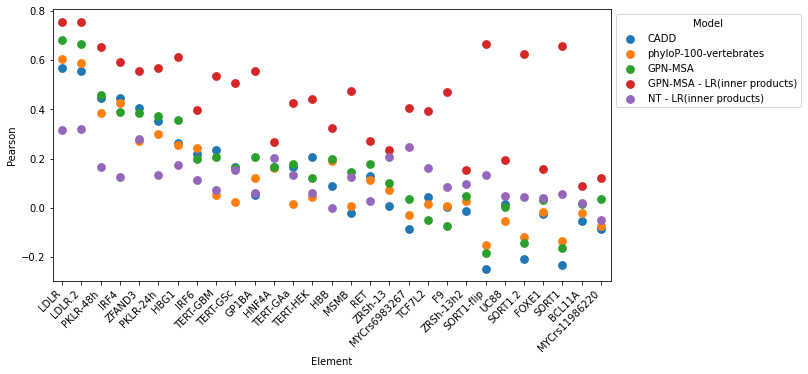

In [12]:
plt.figure(figsize=(10, 5))
g = sns.pointplot(
    #data=results.replace({"GPN-MSA": "GPN-MSA (LLR)"}),
    data=results[~results.Model.str.contains("best") & ~results.Model.str.contains("full")],
    #data=results[results.Model.str.contains("GPN-MSA")],
    hue="Model",
    x="Element",
    y="Pearson",  # "Spearman" or "Pearson"
    join=False,
    order=results.groupby("Element").Pearson.mean().sort_values(ascending=False).index.values,
);
plt.xticks(rotation=45, ha="right");
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));

In [13]:
results.groupby("Element").Pearson.mean().sort_values(ascending=False).index.values

array(['LDLR', 'LDLR.2', 'PKLR-48h', 'IRF4', 'ZFAND3', 'PKLR-24h', 'HBG1',
       'IRF6', 'TERT-GBM', 'TERT-GSc', 'GP1BA', 'HNF4A', 'TERT-GAa',
       'TERT-HEK', 'HBB', 'MSMB', 'RET', 'ZRSh-13', 'MYCrs6983267',
       'TCF7L2', 'F9', 'ZRSh-13h2', 'SORT1-flip', 'UC88', 'SORT1.2',
       'FOXE1', 'SORT1', 'BCL11A', 'MYCrs11986220'], dtype=object)

In [14]:
V.Element.value_counts()

Element
FOXE1            1800
BCL11A           1799
SORT1.2          1798
RET              1797
MYCrs6983267     1792
SORT1-flip       1791
SORT1            1790
IRF6             1785
MSMB             1773
TCF7L2           1770
UC88             1761
ZFAND3           1736
ZRSh-13          1455
ZRSh-13h2        1455
PKLR-48h         1407
PKLR-24h         1407
MYCrs11986220    1389
IRF4             1353
GP1BA            1154
LDLR.2            954
LDLR              954
F9                904
HNF4A             855
HBG1              822
TERT-GAa          777
TERT-GBM          777
TERT-GSc          777
TERT-HEK          777
HBB               561
Name: count, dtype: int64

## Generalization across elements

In [15]:
np.unique(V.Element)

array(['BCL11A', 'F9', 'FOXE1', 'GP1BA', 'HBB', 'HBG1', 'HNF4A', 'IRF4',
       'IRF6', 'LDLR', 'LDLR.2', 'MSMB', 'MYCrs11986220', 'MYCrs6983267',
       'PKLR-24h', 'PKLR-48h', 'RET', 'SORT1', 'SORT1-flip', 'SORT1.2',
       'TCF7L2', 'TERT-GAa', 'TERT-GBM', 'TERT-GSc', 'TERT-HEK', 'UC88',
       'ZFAND3', 'ZRSh-13', 'ZRSh-13h2'], dtype=object)

In [16]:
V["cell_line"] = V.Element.map({
    "F9": "HepG2",
    "LDLR": "HepG2",
    "SORT1": "HepG2",
    "GP1BA": "HEL 92.1.7",
    "HBB": "HEL 92.1.7",
    "HBG1": "HEL 92.1.7",
    "BCL11A": "HEL 92.1.7",
    # TODO: continue
})
V.groupby("cell_line").Element.nunique()

cell_line
HEL 92.1.7    4
HepG2         3
Name: Element, dtype: int64

In [17]:
n_elements_per_cell_line = V.groupby("cell_line").Element.nunique()
n_elements_per_cell_line

cell_line
HEL 92.1.7    4
HepG2         3
Name: Element, dtype: int64

In [18]:
test_cell_lines = n_elements_per_cell_line[n_elements_per_cell_line >= 3].index.values
test_cell_lines

array(['HEL 92.1.7', 'HepG2'], dtype=object)

In [19]:
# TODO: maybe call this V2 or something, make a copy (before setting the supervised models)
# this should not be run after the previous one...

def train_predict_lr_split_across_elements(V, model_name, model):
    elements = np.unique(V.Element)
    for element in elements:
        mask_train = V.Element != element
        mask_test = ~mask_train
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])
    return V[model_name].values
        

for cell_line in tqdm(test_cell_lines):
    V_e = V[V.cell_line==cell_line]
    for m, model in supervised_models:
        V.loc[V.cell_line==cell_line, m] = train_predict_lr_split_across_elements(V_e, m, model)
        if m not in models: models.append(m)
V

100%|██████████| 2/2 [00:41<00:00, 20.64s/it]


,chrom,pos,ref,alt,Tags,DNA,RNA,Value,P-Value,Element,...,NT_embedding_2554,NT_embedding_2555,NT_embedding_2556,NT_embedding_2557,NT_embedding_2558,NT_embedding_2559,label,GPN-MSA - LR(inner products),NT - LR(inner products),cell_line
0,2,60494940,C,A,146,2785,6772,-0.05,0.38889,BCL11A,...,280.904968,639.018616,611.724182,393.658295,246.889572,438.870209,0.05,0.949714,-1.704808,HEL 92.1.7
1,2,60494940,C,G,60,975,2436,-0.13,0.13721,BCL11A,...,280.716614,638.803955,613.168945,393.661713,247.011124,439.019897,0.13,0.888144,-1.708850,HEL 92.1.7
2,2,60494940,C,T,1084,8543,16057,-0.70,0.00000,BCL11A,...,280.945099,638.307739,612.376953,393.744720,246.844040,438.470886,0.70,0.951108,-1.696908,HEL 92.1.7
3,2,60494941,C,A,596,9425,23430,-0.08,0.00413,BCL11A,...,275.491791,582.535522,625.180237,415.684326,251.629257,489.781494,0.08,0.919881,-1.725495,HEL 92.1.7
4,2,60494941,C,G,75,1506,3697,-0.06,0.47756,BCL11A,...,275.479004,582.367126,626.136963,415.015259,251.971130,488.997864,0.06,0.892691,-1.723264,HEL 92.1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39165,7,156791602,G,C,358,2279,7044,0.04,0.39490,ZRSh-13h2,...,292.959381,725.619385,483.129639,444.974670,288.532288,566.185303,0.04,-0.062691,-0.013546,NaN
39166,7,156791602,G,T,1676,12030,37310,0.10,0.00001,ZRSh-13h2,...,290.691437,722.373108,482.941101,442.876526,288.728088,555.536621,0.10,-0.062872,-0.015167,NaN
39167,7,156791603,C,A,25,107,309,-0.17,0.33374,ZRSh-13h2,...,247.580978,644.393799,482.822723,497.064911,270.218353,438.244843,0.17,-0.058924,-0.051151,NaN
39168,7,156791603,C,G,654,4748,14458,0.06,0.09092,ZRSh-13h2,...,247.332809,645.774658,483.212708,496.339264,270.630676,438.434357,0.06,-0.058565,-0.051021,NaN


In [20]:
rows = []
for cell_line in tqdm(test_cell_lines):
    V_e = V[V.cell_line==cell_line]
    y = V_e.label
    for m in models:
        x = -V_e[m]
        rows.append([
            cell_line,
            m,
            pearsonr(x, y)[0],
            spearmanr(x, y)[0],
        ])
results = pd.DataFrame(rows, columns=["cell_line", "Model", "Pearson", "Spearman"])
results

100%|██████████| 2/2 [00:00<00:00, 16.86it/s]


,cell_line,Model,Pearson,Spearman
0,HEL 92.1.7,CADD,0.137032,0.120994
1,HEL 92.1.7,phyloP-100-vertebrates,0.105196,0.020466
2,HEL 92.1.7,GPN-MSA,0.211550,0.092708
3,HEL 92.1.7,GPN-MSA - LR(inner products),0.150296,0.161879
4,HEL 92.1.7,NT - LR(inner products),-0.252502,-0.352641
5,HepG2,CADD,0.117361,0.109550
6,HepG2,phyloP-100-vertebrates,0.153360,0.126205
7,HepG2,GPN-MSA,0.179922,0.172447
8,HepG2,GPN-MSA - LR(inner products),0.218158,0.251186
9,HepG2,NT - LR(inner products),0.157148,0.189316


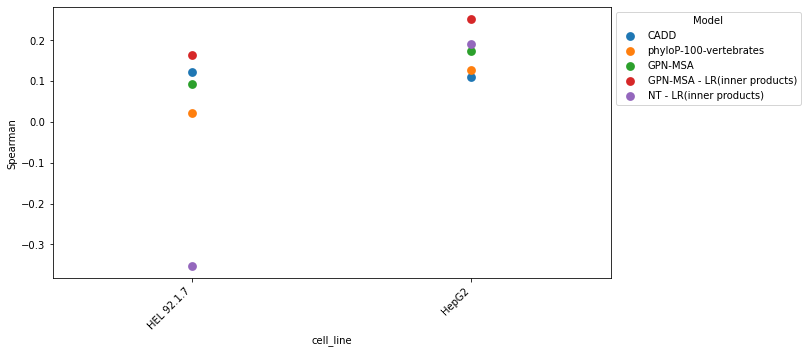

In [21]:
plt.figure(figsize=(10, 5))
g = sns.pointplot(
    data=results[~results.Model.str.contains("best") & ~results.Model.str.contains("full")],
    hue="Model",
    x="cell_line",
    y="Spearman",  # "Spearman" or "Pearson"
    join=False,
);
plt.xticks(rotation=45, ha="right");
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));